In [5]:
import json
import os
from collections import defaultdict
import traceback
import xml.etree.ElementTree as ET
from xml.dom import minidom
import argparse

import fitz
from fitz import Rect
from PIL import Image
import numpy as np
from tqdm import tqdm
import editdistance

# code tham khao

In [6]:
def adjust_bbox_coordinates(table_dict, doc):
    # Change bbox coordinates to be relative to PyMuPDF page.rect coordinate space
    mediabox = doc[table_dict['pdf_page_index']].mediabox
    mat = doc[table_dict['pdf_page_index']].transformation_matrix

    for cell in table_dict['cells']:
        if not 'pdf_text_tight_bbox' in cell or len(cell['pdf_text_tight_bbox']) == 0:
            continue
        bbox = list(Rect(cell['pdf_text_tight_bbox']))
        bbox = [bbox[0] + mediabox[0],
                bbox[1] - mediabox[3] + mediabox[2],
                bbox[2] + mediabox[0],
                bbox[3] - mediabox[3] + mediabox[2]]
        cell['pdf_text_tight_bbox'] = bbox

def create_document_page_image(doc, page_num, zoom=None, output_image_max_dim=1000):
    page = doc[page_num]
    
    if zoom is None:
        zoom = output_image_max_dim / max(page.rect)
        
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix = mat, alpha = False)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    return img

def create_table_dict(doc, region, partial_table=False):
    table_dict = {}
    table_dict['reject'] = []
    table_dict['fix'] = []
    table_dict['partial_table'] = partial_table
    table_dict['cells'] = []

    page_num = int(region.get("page")) - 1
    page = doc[page_num]

    max_row = -1
    max_column = -1
    cell_presence_by_grid_location = defaultdict(bool)
    for cell in region.iter('cell'):
        table_cell = {}
        bbox = cell.find('bounding-box')
        bbox = [int(bbox.get('x1')),
                page.mediabox[3] - int(bbox.get('y2')) + 1,
                int(bbox.get('x2')),
                page.mediabox[3] - int(bbox.get('y1')) + 1]
        table_cell['pdf_text_tight_bbox'] = bbox
        table_cell['text_content'] = cell.find('content').text

        start_row = int(cell.get('start-row'))
        start_column = int(cell.get('start-col'))

        try:
            end_row = int(cell.get('end-row'))
        except:
            end_row = start_row

        try:
            end_column = int(cell.get('end-col'))
        except:
            end_column = start_column
        if end_column < start_column:
            print("END COLUMN BEFORE START COLUMN")
            end_column = 10

        table_cell['row_nums'] = list(range(start_row, end_row + 1))
        table_cell['column_nums'] = list(range(start_column, end_column + 1))
        table_cell['is_column_header'] = False

        table_dict['cells'].append(table_cell)

        if len(table_cell['column_nums']) == 0 or len(table_cell['row_nums']) == 0:
            print("Empty or negative grid locations: {}".format(table_cell))
            #raise Exception("Empty or negative grid locations: {}".format(table_cell))

        max_row = max(max_row, table_cell['row_nums'][-1])
        max_column = max(max_column, table_cell['column_nums'][-1])
        overlap = False
        for row_num in table_cell['row_nums']:
            for column_num in table_cell['column_nums']:
                if cell_presence_by_grid_location[(row_num, column_num)]:
                    overlap = True
                    print("Bad table, some cells intersect/overlap within the grid: ({}, {})".format(row_num, column_num))
                cell_presence_by_grid_location[(row_num, column_num)] = True
        if overlap:
            table_dict['reject'].append('HTML grid cells overlap')

    # Create missing cells
    for row_num in range(max_row + 1):
        for column_num in range(max_column + 1):
            if not (row_num, column_num) in cell_presence_by_grid_location:
                table_cell = {}
                table_cell['pdf_text_tight_bbox'] = []
                table_cell['text_content'] = ''
                table_cell['row_nums'] = list(range(row_num, row_num + 1))
                table_cell['column_nums'] = list(range(column_num, column_num + 1))
                table_cell['is_column_header'] = False
                
                table_dict['cells'].append(table_cell)

    num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
    num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
    expected_num_cells = num_rows * num_columns
    #actual_num_cells = len(grid_cell_locations)
        
    # Make sure all grid locations are present
    # Could be bad data or bad parsing algorithm
    #if not expected_num_cells == actual_num_cells:
    #    table_dict['reject'].append("HTML missing grid cells")
        
    table_dict['rows'] = {row_num: {'is_column_header': False} for row_num in range(num_rows)}
    table_dict['columns'] = {column_num: {} for column_num in range(num_columns)}
                
    table_dict['pdf_page_index'] = page_num
    return table_dict

def read_xml(xml_file, doc):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    tables = []

    for table_tree in root.iter('table'):
        table_id = table_tree.attrib['id']
        page_nums = [int(region.get("page"))-1 for region in table_tree.iter('region')]
        for region_num, region in enumerate(table_tree.iter('region')):
            region_id = region.attrib['id']
            if region_num > 0 and not page_nums[region_num] == page_nums[region_num-1]:
                partial_table = True
            else:
                partial_table = False
            table_dict = create_table_dict(doc, region, partial_table=partial_table)
            table_dict['icdar2013_source_table_id'] = table_id
            table_dict['icdar2013_source_region_id'] = region_id
            tables.append(table_dict)

    return tables

def complete_table_grid(table_dict):
    rects_by_row = defaultdict(lambda: [None, None, None, None])
    rects_by_column = defaultdict(lambda: [None, None, None, None])
    table_rect = Rect()

    # Determine bounding box for rows and columns
    for cell in table_dict['cells']:
        if not 'pdf_text_tight_bbox' in cell or len(cell['pdf_text_tight_bbox']) == 0:
            continue

        bbox = cell['pdf_text_tight_bbox'] 

        table_rect.include_rect(list(bbox))
        
        min_row = min(cell['row_nums'])
        if rects_by_row[min_row][1] is None:
            rects_by_row[min_row][1] = bbox[1]
        else:
            rects_by_row[min_row][1] = min(rects_by_row[min_row][1], bbox[1])
            
        max_row = max(cell['row_nums'])
        if rects_by_row[max_row][3] is None:
            rects_by_row[max_row][3] = bbox[3]
        else:
            rects_by_row[max_row][3] = max(rects_by_row[max_row][3], bbox[3])
            
        min_column = min(cell['column_nums'])
        if rects_by_column[min_column][0] is None:
            rects_by_column[min_column][0] = bbox[0]
        else:
            rects_by_column[min_column][0] = min(rects_by_column[min_column][0], bbox[0])
            
        max_column = max(cell['column_nums'])
        if rects_by_column[max_column][2] is None:
            rects_by_column[max_column][2] = bbox[2]
        else:
            rects_by_column[max_column][2] = max(rects_by_column[max_column][2], bbox[2])

    table_bbox = list(table_rect)
    table_dict['pdf_table_bbox'] = table_bbox

    for row_num, row_rect in rects_by_row.items():
        row_rect[0] = table_bbox[0]
        row_rect[2] = table_bbox[2]

    for col_num, col_rect in rects_by_column.items():
        col_rect[1] = table_bbox[1]
        col_rect[3] = table_bbox[3]
        
    for k, row in table_dict['rows'].items():
        v = rects_by_row[k]
        table_dict['rows'][k]['pdf_row_bbox'] = list(v)
    for k, column in table_dict['columns'].items():
        v = rects_by_column[k]
        table_dict['columns'][k]['pdf_column_bbox'] = list(v)
        
    for k, row in table_dict['rows'].items():    
        for elem in row['pdf_row_bbox']:
            if elem is None:
                table_dict['reject'].append("undetermined row boundary")
    for k, column in table_dict['columns'].items():
        for elem in column['pdf_column_bbox']:
            if elem is None:
                table_dict['reject'].append("undetermined column boundary")
                
    # Adjust bounding boxes if minor overlap
    fixed_overlap = False
    num_rows = len(table_dict['rows'])
    for row_num in range(num_rows-1):
        row1_bbox = table_dict['rows'][row_num]['pdf_row_bbox']
        row2_bbox = table_dict['rows'][row_num+1]['pdf_row_bbox']
        overlap1 = overlap(row1_bbox, row2_bbox)
        overlap2 = overlap(row2_bbox, row1_bbox)
        
        if overlap1 > 0 and overlap2 > 0:
            if overlap1 < 0.22 and overlap2 < 0.22:
                fixed_overlap = True
                midpoint = 0.5 * (row1_bbox[3] + row2_bbox[1])
                table_dict['rows'][row_num]['pdf_row_bbox'][3] = midpoint
                table_dict['rows'][row_num+1]['pdf_row_bbox'][1] = midpoint
                fixed_overlap = True
            else:
                table_dict['reject'].append("rows intersect: {} {} ({}), {} {} ({})".format(row_num, row1_bbox, overlap1, row_num+1, row2_bbox, overlap2))
        
    # Intersect each row and column to determine grid cell bounding boxes
    #page_words = page.get_text_words()
    for cell in table_dict['cells']:
        rows_rect = Rect()
        cols_rect = Rect()

        for row_num in cell['row_nums']:
            rows_rect.include_rect(table_dict['rows'][row_num]['pdf_row_bbox'])

        for col_num in cell['column_nums']:
            cols_rect.include_rect(table_dict['columns'][col_num]['pdf_column_bbox'])

        pdf_bbox = rows_rect.intersect(cols_rect)
        cell['pdf_bbox'] = list(pdf_bbox)

def identify_projected_row_headers(table_dict):
    num_cols = len(table_dict['columns'])
    cells_with_text_count_by_row = defaultdict(int)
    all_cells_in_row_only_in_one_row_by_row = defaultdict(lambda: True)
    has_first_column_cell_with_text_by_row = defaultdict(bool)
    for cell in table_dict['cells']:
        if len(cell['text_content']) > 0:
            for row_num in cell['row_nums']:
                cells_with_text_count_by_row[row_num] += 1

            if 0 in cell['column_nums']:
                has_first_column_cell_with_text_by_row[row_num] = True

        one_row_only = len(cell['row_nums']) == 1
        for row_num in cell['row_nums']:
            all_cells_in_row_only_in_one_row_by_row[row_num] = all_cells_in_row_only_in_one_row_by_row[row_num] and one_row_only

    projected_row_header_rows = set()
    for row_num, row in table_dict['rows'].items():
        if (not row['is_column_header'] and cells_with_text_count_by_row[row_num] == 1
                and all_cells_in_row_only_in_one_row_by_row[row_num]
                and has_first_column_cell_with_text_by_row[row_num]):
            projected_row_header_rows.add(row_num)
            
    return projected_row_header_rows

def annotate_projected_row_headers(table_dict, exclude=[]):    
    num_cols = len(table_dict['columns'])
    projected_row_header_rows = identify_projected_row_headers(table_dict)
    
    projected_row_header_rows -= set(exclude)

    cells_to_remove = []
    for cell in table_dict['cells']:
        if len(set(cell['row_nums']).intersection(projected_row_header_rows)) > 0:
            if len(cell['text_content']) > 0:
                cell['column_nums'] = list(range(num_cols))
                cell['is_projected_row_header'] = True
            else:
                cells_to_remove.append(cell) # Consolidate blank cells after the first cell into the projected row header
        else:
            cell['is_projected_row_header'] = False

    for cell in cells_to_remove:
        table_dict['fix'].append('merged projected row header')
        table_dict['cells'].remove(cell)
        
    for row_num, row in table_dict['rows'].items():
        if row_num in projected_row_header_rows:
            row['is_projected_row_header'] = True
        else:
            row['is_projected_row_header'] = False
            
    # Delete projected row headers in first rows
    num_rows = len(table_dict['rows'])
    row_nums_to_delete = []
    for row_num in range(0, num_rows):
        if table_dict['rows'][row_num]['is_projected_row_header']:
            row_nums_to_delete.append(row_num)
        else:
            break
            
    if len(row_nums_to_delete) > 0:
        for row_num in row_nums_to_delete:
            del table_dict['rows'][row_num]
            table_dict['fix'].append('removed projected row header at top of table')
            for cell in table_dict['cells'][:]:
                if row_num in cell['row_nums']:
                    table_dict['cells'].remove(cell)
                    
        table_dict['rows'] = {k-len(row_nums_to_delete): v for k, v in table_dict['rows'].items()}
        for cell in table_dict['cells']:
            cell['row_nums'] = [row_num-len(row_nums_to_delete) for row_num in cell['row_nums']]
            
    # Delete projected row headers in last rows
    num_rows = len(table_dict['rows'])
    row_nums_to_delete = []
    for row_num in range(num_rows-1, -1, -1):
        if table_dict['rows'][row_num]['is_projected_row_header']:
            row_nums_to_delete.append(row_num)
        else:
            break
            
    if len(row_nums_to_delete) > 0:
        for row_num in row_nums_to_delete:
            del table_dict['rows'][row_num]
            table_dict['fix'].append('removed projected row header at bottom of table')
            for cell in table_dict['cells'][:]:
                if row_num in cell['row_nums']:
                    table_dict['cells'].remove(cell)

def merge_group(table_dict, group):
    cells_to_delete = []
    if len(group) == 1:
        return table_dict
    group = sorted(group, key=lambda k: min(k['row_nums'])) 
    cell = group[0]
    try:
        cell_text_rect = Rect(cell['pdf_text_tight_bbox'])
    except:
        cell_text_rect = Rect()
    for cell2 in group[1:]:
        cell['row_nums'] = list(set(sorted(cell['row_nums'] + cell2['row_nums'])))
        cell['column_nums'] = list(set(sorted(cell['column_nums'] + cell2['column_nums'])))
        cell['text_content'] = (cell['text_content'].strip() + " " + cell2['text_content'].strip()).strip()
        try:
            cell2_text_rect = Rect(cell2['pdf_text_tight_bbox'])
        except:
            cell2_text_rect = Rect()
        cell_text_rect = cell_text_rect.include_rect(list(cell2_text_rect))
        if cell_text_rect.get_area() == 0:
            cell['pdf_text_tight_bbox'] = []
        else:
            cell['pdf_text_tight_bbox'] = list(cell_text_rect)
        cell['is_projected_row_header'] = False
        cells_to_delete.append(cell2)
        
    try:
        for cell in cells_to_delete:
            table_dict['cells'].remove(cell)
            table_dict['fix'].append('merged oversegmented spanning cell')
    except:
        table_dict['reject'].append("ambiguous spanning cell")
        #raise AmbiguousSpanningCellException

def remove_empty_rows(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    has_content_by_row = defaultdict(bool)
    for cell in table_dict['cells']:
        has_content = len(cell['text_content'].strip()) > 0
        for row_num in cell['row_nums']:
            has_content_by_row[row_num] = has_content_by_row[row_num] or has_content
    row_num_corrections = np.cumsum([int(not has_content_by_row[row_num]) for row_num in range(num_rows)]).tolist()
    
    # Delete cells in empty rows and renumber other cells
    cells_to_delete = []
    for cell in table_dict['cells']:
        new_row_nums = []
        for row_num in cell['row_nums']:
            if has_content_by_row[row_num]:
                new_row_nums.append(row_num - row_num_corrections[row_num])
        cell['row_nums'] = new_row_nums
        if len(new_row_nums) == 0:
            cells_to_delete.append(cell)
    for cell in cells_to_delete:
        table_dict['fix'].append('removed empty row')
        table_dict['cells'].remove(cell)
    
    rows = {}
    for row_num, has_content in has_content_by_row.items():
        if has_content:
            new_row_num = row_num - row_num_corrections[row_num]
            rows[new_row_num] = table_dict['rows'][row_num]
    table_dict['rows'] = rows
    
def merge_rows(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    co_occurrence_matrix = np.zeros((num_rows, num_rows))
    for cell in table_dict['cells']:
        for row_num1 in cell['row_nums']:
            for row_num2 in cell['row_nums']:
                if row_num1 >= row_num2:
                    continue
                co_occurrence_matrix[row_num1, row_num2] += len(cell['column_nums'])
                
    new_row_num = 0
    current_row_group = 0
    keep_row = [True]
    row_grouping = [current_row_group]
    for row_num in range(num_rows-1):
        if not co_occurrence_matrix[row_num, row_num+1] == num_columns:
            keep_row.append(True)
            new_row_num += 1
        else:
            table_dict['fix'].append('merged rows spanned together in every column')
            keep_row.append(False)
        row_grouping.append(new_row_num)

    for cell in table_dict['cells']:
        cell['row_nums'] = [row_grouping[row_num] for row_num in cell['row_nums'] if keep_row[row_num]]
        
    table_dict['rows'] = {row_grouping[row_num]: table_dict['rows'][row_num] for row_num in range(num_rows) if keep_row[row_num]} 
            
        
def remove_empty_columns(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    has_content_by_column = defaultdict(bool)
    for cell in table_dict['cells']:
        has_content = len(cell['text_content'].strip()) > 0
        for column_num in cell['column_nums']:
            has_content_by_column[column_num] = has_content_by_column[column_num] or has_content
    column_num_corrections = np.cumsum([int(not has_content_by_column[column_num]) for column_num in range(num_columns)]).tolist()
    
    # Delete cells in empty columns and renumber other cells
    cells_to_delete = []
    for cell in table_dict['cells']:
        new_column_nums = []
        for column_num in cell['column_nums']:
            if has_content_by_column[column_num]:
                new_column_nums.append(column_num - column_num_corrections[column_num])
        cell['column_nums'] = new_column_nums
        if len(new_column_nums) == 0:
            cells_to_delete.append(cell)
    for cell in cells_to_delete:
        table_dict['fix'].append('removed empty column')
        table_dict['cells'].remove(cell)
    
    columns = {}
    for column_num, has_content in has_content_by_column.items():
        if has_content:
            new_column_num = column_num - column_num_corrections[column_num]
            columns[new_column_num] = table_dict['columns'][column_num]
    table_dict['columns'] = columns
    
def merge_columns(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    co_occurrence_matrix = np.zeros((num_columns, num_columns))
    for cell in table_dict['cells']:
        for column_num1 in cell['column_nums']:
            for column_num2 in cell['column_nums']:
                if column_num1 >= column_num2:
                    continue
                co_occurrence_matrix[column_num1, column_num2] += len(cell['row_nums'])
                
    new_column_num = 0
    current_column_group = 0
    keep_column = [True]
    column_grouping = [current_column_group]
    for column_num in range(num_columns-1):
        if not co_occurrence_matrix[column_num, column_num+1] == num_rows:
            keep_column.append(True)
            new_column_num += 1
        else:
            table_dict['fix'].append('merged columns spanned together in every row')
            keep_column.append(False)
        column_grouping.append(new_column_num)

    for cell in table_dict['cells']:
        cell['column_nums'] = [column_grouping[column_num] for column_num in cell['column_nums'] if keep_column[column_num]]
        
    table_dict['columns'] = {column_grouping[column_num]: table_dict['columns'][column_num] for column_num in range(num_columns) if keep_column[column_num]}

# Look for tables with blank cells to merge in the first column
def merge_spanning_cells_in_first_column(table_dict, first_column_merge_exclude=[]):
    numeric_count_by_column = defaultdict(int)
    alpha_count_by_column = defaultdict(int)
    for cell in table_dict['cells']:
        if cell['is_column_header'] or cell['is_projected_row_header']:
            continue
        numeric_count = sum([1 for ch in cell['text_content'] if ch.isnumeric()])
        alpha_count = sum([1 for ch in cell['text_content'] if ch.isalpha()])
        for column_num in cell['column_nums']:
            numeric_count_by_column[column_num] += numeric_count
            alpha_count_by_column[column_num] += alpha_count
    if not alpha_count_by_column[1] > numeric_count_by_column[1]:
        return

    first_column_cells = [cell for cell in table_dict['cells'] if 0 in cell['column_nums']]
    first_column_cells = sorted(first_column_cells, key=lambda item: max(item['row_nums']))
    
    current_filled_cell = None
    groups = defaultdict(list)
    group_num = -1
    for cell in first_column_cells:
        if len(set(cell['row_nums']).intersection(set(first_column_merge_exclude))) > 0:
            group_num += 1
        elif len(cell['text_content']) > 0:
            group_num += 1
        if group_num >= 0:
            groups[group_num].append(cell)
        
    for group_num, group in groups.items():
        if len(group) > 1 and not group[0]['is_projected_row_header'] and not group[0]['is_column_header']:
            merge_group(table_dict, group)

# STANDARDS:
# 1. Column header, if it exists, is a tree structure. FinTabNet contains no header annotation so we can only
#    infer the header given some assumptions. If the top row does not contain all leaf nodes, complete the tree down to the
#    leaf nodes.
# 2. There should be no blank cells in the column header. Blank cells should be aggregated into supercells where possible.
#    - First, blank supercells should be split into blank grid cells.
#    - If a column header cell has only blank grid cells directly below it, extend the cell downward to consume
#      any rows of entirely blank cells directly below it.
#    - After doing this for all column header cells, if a column header cell has only blank cells above it, consume 
#      any rows of entirely blank cells directly above it.
#    - Blank supercells that occur after this grouping are arguably rightly annotated as supercells, but we will not
#      annotate these as supercells at the moment for consistency with previous datasets that annotated these as blank
#      cells only. Detecting a blank supercell would not impact the structure inferred for the table.
#    - Any remaining blank cells are ambiguous, and while it is not good table design to have these, they're not likely
#      to be a nuisance.
# 3. There should be no blank cells in the row header. This is trickier because the row header is not explicitly
#    annotated and must be inferred. See below for more on determining which columns are in the row header.
#    - For columns in the row header, blank cells should be aggregated under the first cell that does not span the
#      entire row. This assumes "top" vertical alignment for text. "Middle" vertical alignment is normally already
#      associated with supercells and is already explicit.
# 4. Inferring the row header.
#    - The row header is explicit whenever the first N columns do not have a column header. In other words, when
#      the stub header is blank. Otherwise it is implicit which columns, if any, correspond to the column header.
#    - If a row header exists, it is also a tree just like the column header and must end at a column of leaf nodes.
#      Not only does this mean supercells cannot be the final column of a row header, but repeated values in a column
#      mean that the column cannot be the final column of a row header.
#    - A column that is not part of the row header (possibly the first column) can have repeated values. Having repeated
#      values is an indication of row header continuation but not of row header status to begin with.
#    - In most cases, numeric values are data. If the numeric values are integer and sorted, this may be part of the row
#      header.
#    - Rows where only one cell has content, either left justified or centered across the table, are part of an implicit
#      first column that begins a row header. The stub header belongs in this first column if there is not a row cell.
# 5. A row cell at the top of the table is either the title of the table (if there are no other row cells in the table),
#    or part of the row header if there are additional row cells below, and belongs in an implicit column.
# 6. Tables have at least one row and two columns. A table with only one column is a list.

def correct_header(table_dict, n=2, assume_header_if_more_than_n_columns=True, last_header_row=None):
    num_columns = len(table_dict['columns'])
    num_rows = len(table_dict['rows'])
    
    if last_header_row is None:

        if num_columns < 2 or num_rows < 1:
            table_dict['reject'].append("small table")
            #raise SmallTableException("Table does not have at least one row and two columns") 

        #---DETERMINE FULL EXTENT OF COLUMN HEADER
        # - Each of the below steps determines different rows that must be in the column header.
        # - The final column header includes all rows that are originally annotated as being in the column
        #   header plus any additional rows determined to be in the column header by the following steps.

        table_has_column_header = False

        # First determine if there is definitely a column header. Four cases:

        # 1. We specify that we want to assume there is one for all tables with more than two columns:
        if assume_header_if_more_than_n_columns and num_columns > n:
            table_has_column_header = True

        # 2. An annotator says there is
        if not table_has_column_header:
            header_rows = [row_num for row_num, row in table_dict['rows'].items() if row['is_column_header']]
            if 0 in header_rows:
                table_has_column_header = True

        # 3. The cell occupying the first row and column is blank
        if not table_has_column_header:
            for cell in table_dict['cells']:
                if 0 in cell['column_nums'] and 0 in cell['row_nums'] and len(cell['text_content'].strip()) == 0:
                    table_has_column_header = True
                    break

        # 4. There is a horizontal spanning cell in the first row
        if not table_has_column_header:
            for cell in table_dict['cells']:
                if 0 in cell['row_nums'] and len(cell['column_nums']) > 1:
                    table_has_column_header = True
                    break

        # Then determine if the column header needs to be extended past its current annotated extent.
        #  1. A header that already is annotated in at least one row continues at least until each column
        #     has a cell occupying only that column
        #  2. A header with a column with a blank cell must continue at least as long as the blank cells continue
        #     (unless rule #1 is satisfied and a possible projected row header is reached?)
        if table_has_column_header:
            first_column_filled_by_row = defaultdict(bool)
            for cell in table_dict['cells']:
                if 0 in cell['column_nums']:
                    if len(cell['text_content']) > 0:
                        for row_num in cell['row_nums']:
                            first_column_filled_by_row[row_num] = True

            first_single_node_row_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
            for cell in table_dict['cells']:
                if len(cell['column_nums']) == 1:
                    first_single_node_row_by_column[cell['column_nums'][0]] = min(first_single_node_row_by_column[cell['column_nums'][0]],
                                                                                   max(cell['row_nums']))

            first_filled_single_node_row_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
            for cell in table_dict['cells']:
                if len(cell['column_nums']) == 1 and len(cell['text_content'].strip()) > 0:
                    first_filled_single_node_row_by_column[cell['column_nums'][0]] = min(first_filled_single_node_row_by_column[cell['column_nums'][0]],
                                                                                   max(cell['row_nums']))

            first_filled_cell_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
            for cell in table_dict['cells']:
                if len(cell['text_content']) > 0:
                    min_row_num = min(cell['row_nums'])
                    for column_num in cell['column_nums']:
                        first_filled_cell_by_column[column_num] = min(first_filled_cell_by_column[column_num],
                                                                      min_row_num)

            projected_row_header_rows = identify_projected_row_headers(table_dict)
            if 0 in projected_row_header_rows:
                table_dict['reject'].append("bad projected row header")
                #raise BadProjectedRowHeaderException('Starting with PRH')
            #for row_num in range(num_rows):
            #    if row_num in projected_row_header_rows:
            #        projected_row_header_rows.remove(row_num)
            #    else:
            #        break

            # Header must continue until at least this row
            minimum_grid_cell_single_node_row = max(first_single_node_row_by_column.values())

            # Header can stop prior to the first of these rows that occurs after the above row
            minimum_first_body_row = min(num_rows-1, max(first_filled_cell_by_column.values()))

            # Determine the max row for which a column N has been single and filled but column N+1 has not
            minimum_all_following_filled = -1
            for row_num in range(num_rows):
                for column_num1 in range(num_columns-1):
                    for column_num2 in range(column_num1+1, num_columns):
                        if (first_filled_single_node_row_by_column[column_num2] > row_num
                            and first_filled_single_node_row_by_column[column_num1] < first_filled_single_node_row_by_column[column_num2]):
                            minimum_all_following_filled = row_num + 1

            #minimum_projected_row_header_row = min([num_rows-1] + [elem for elem in projected_row_header_rows if elem > minimum_grid_cell_single_node_row])
            if len(projected_row_header_rows) > 0:
                minimum_projected_row_header_row = min(projected_row_header_rows)
            else:
                minimum_projected_row_header_row = num_rows

            #first_possible_last_header_row = min(minimum_first_body_row, minimum_projected_row_header_row) - 1
            first_possible_last_header_row = minimum_first_body_row - 1

            last_header_row = max(minimum_all_following_filled,
                                  minimum_grid_cell_single_node_row,
                                  first_possible_last_header_row)

            x = last_header_row
            while(last_header_row < num_rows and not first_column_filled_by_row[last_header_row+1]):
                last_header_row += 1

            #incomplete_header = False # temp for debugging
            if minimum_projected_row_header_row <= last_header_row:
                last_header_row = minimum_projected_row_header_row - 1
                #incomplete_header = True
                
    else:
        table_has_column_header = True
            
    if last_header_row == 0 and table_dict['partial_table']:
        last_header_row = -1
    del table_dict['partial_table']

    for cell in table_dict['cells']:
        if max(cell['row_nums']) <= last_header_row:
            cell['is_column_header'] = True

    for row_num, row in table_dict['rows'].items():
        if row_num <= last_header_row:
            row['is_column_header'] = True

    #if not x == last_header_row:
    #    raise DebugException("Header extended")

    #if minimum_all_following_filled == last_header_row:
    #    raise DebugException

    #if incomplete_header:
    #    raise IncompleteHeaderException("Set last header row to be just before minimum projected row header row".format(last_header_row, minimum_projected_row_header_row))
    
    if not table_has_column_header and num_columns == 2:
        table_dict['reject'].append("ambiguous header")
        #raise AmbiguousHeaderException("Missing header annotation for table with two columns; cannot unambiguously determine header")

def canonicalize(table_dict, first_column_merge_exclude=[]):
    # Preprocessing step: Split every blank spanning cell in the column header into blank grid cells.
    cells_to_delete = []
    try:
        for cell in table_dict['cells']:
            if (cell['is_column_header'] and len(cell['text_content'].strip()) == 0
                    and (len(cell['column_nums']) > 1 or len(cell['row_nums']) > 1)):
                cells_to_delete.append(cell)
                # Split this blank spanning cell into blank grid cells
                for column_num in cell['column_nums']:
                    for row_num in cell['row_nums']:
                        #row_bbox = table_dict['rows'][row_num]['pdf_row_bbox']
                        #column_bbox = table_dict['columns'][column_num]['pdf_column_bbox']
                        #bbox = list(Rect(row_bbox).intersect(list(column_bbox)))
                        new_cell = {'text_content': '',
                                    'column_nums': [column_num],
                                    'row_nums': [row_num],
                                    'is_column_header': cell['is_column_header'],
                                    'pdf_text_tight_bbox': [],
                                    'is_projected_row_header': False}
                        table_dict['cells'].append(new_cell)
    except:
        print(traceback.format_exc())
    for cell in cells_to_delete:
        table_dict['cells'].remove(cell)
        
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
        
    # Go bottom up, try to extend non-blank cells up to absorb blank cells
    header_groups = []
    for cell in table_dict['cells']:
        if not cell['is_column_header'] or len(cell['text_content']) == 0:
            continue
        header_group = [cell]
        next_row_num = min(cell['row_nums']) - 1
        for row_num in range(next_row_num, -1, -1):
            all_are_blank = True
            for column_num in cell['column_nums']:
                cell2 = cell_grid_index[(row_num, column_num)]
                all_are_blank = all_are_blank and len(cell2['text_content']) == 0
            if all_are_blank:
                for column_num in cell['column_nums']:
                    header_group.append(cell_grid_index[(row_num, column_num)])
            else:
                break # Stop looking; must be contiguous
        if len(header_group) > 1:
            header_groups.append(header_group)
    for group in header_groups:
        merge_group(table_dict, group)
            
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
                
    num_rows = len(table_dict['rows'])
    # Go top down, try to extend non-blank cells down to absorb blank cells
    header_groups = []
    for cell in table_dict['cells']:
        if not cell['is_column_header'] or len(cell['text_content']) == 0:
            continue
        header_group = [cell]
        next_row_num = max(cell['row_nums']) + 1
        for row_num in range(next_row_num, num_rows):
            if not table_dict['rows'][row_num]['is_column_header']:
                break
            all_are_blank = True
            for column_num in cell['column_nums']:
                cell2 = cell_grid_index[(row_num, column_num)]
                all_are_blank = all_are_blank and len(cell2['text_content']) == 0
            if all_are_blank:
                for column_num in cell['column_nums']:
                    header_group.append(cell_grid_index[(row_num, column_num)])
            else:
                break # Stop looking; must be contiguous
        if len(header_group) > 1:
            header_groups.append(header_group)
    for group in header_groups:
        merge_group(table_dict, group)
    
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
        
    # Go top down, merge any neighboring cells occupying the same columns, whether they are blank or not
    header_groups_by_row_column = defaultdict(list)
    header_groups = []
    do_full_break = False
    for row_num in table_dict['rows']:
        for column_num in table_dict['columns']:
            cell = cell_grid_index[(row_num, column_num)]
            if not cell['is_column_header']:
                do_full_break = True
                break
            if len(header_groups_by_row_column[(row_num, column_num)]) > 0:
                continue
            if not row_num == min(cell['row_nums']) and column_num == min(cell['column_nums']):
                continue
            # Start new header group
            header_group = [cell]
            next_row_num = max(cell['row_nums']) + 1
            while next_row_num < num_rows:
                cell2 = cell_grid_index[(next_row_num, column_num)]
                if cell2['is_column_header'] and set(cell['column_nums']) == set(cell2['column_nums']):
                    header_group.append(cell2)
                    for row_num2 in cell2['row_nums']:
                        for column_num2 in cell2['column_nums']:
                            header_groups_by_row_column[(row_num2, column_num2)] = header_group
                else:
                    break
                next_row_num = max(cell2['row_nums']) + 1
            for row_num2 in cell['row_nums']:
                for column_num2 in cell['column_nums']:
                    header_groups_by_row_column[(row_num2, column_num2)] = header_group
            if len(header_group) > 1:
                header_groups.append(header_group)
        if do_full_break:
            break
    for group in header_groups:
        merge_group(table_dict, group)
        
    # Merge spanning cells in the row header
    merge_spanning_cells_in_first_column(table_dict, first_column_merge_exclude=first_column_merge_exclude)

def is_all_dots(text):
    if len(text) > 0 and len(text.replace('.','')) == 0:
        return True
    return False

def extract_pdf_text(table_dict, page_words, threshold=0.5):
    adjusted_text_tight_bbox = False
    for cell in table_dict['cells']:
        pdf_text_tight_bbox = cell['pdf_text_tight_bbox']
        pdf_bbox = cell['pdf_bbox']
        
        cell_page_words = [w for w in page_words if Rect(w[:4]).intersect(list(pdf_bbox)).get_area() / Rect(w[:4]).get_area() > threshold]
        cell_words = [w[4] for w in cell_page_words]
        cell_text = ''.join(cell_words)
        
        # Remove trailing dots from cell_page_words
        # Some of the original annotations include dots in the pdf_text_tight_bbox when they shouldn't
        # This code ensures that those are fixed, plus that dots are not added by extracting text from the
        # entire grid cell
        if len(cell_text) > 2 and cell_text[-1] == '.' and cell_text[-2] == '.':
            for page_word in cell_page_words[::-1]:
                if is_all_dots(page_word[4]):
                    table_dict['fix'].append('removed dots from text cell')
                    cell_page_words.remove(page_word)
                else:
                    break
        
        cell_words_rect = Rect()
        for w in cell_page_words:
            cell_words_rect.include_rect(w[:4])
        cell_words = [w[4] for w in cell_page_words]
        cell_text = ' '.join(cell_words)
        cell_text = cell_text.replace(' .', '.').replace(' ,', ',')
        if cell_text.endswith('...'):
            table_dict['reject'].append("dots retained")
            #raise DotsRetainedException("Dots retained in text [{}] '{}'".format(cell_words, cell_text))
        cell['pdf_text_content'] = cell_text
        if cell_words_rect.get_area() > 0:
            new_pdf_text_tight_bbox = list(cell_words_rect)
            if not pdf_text_tight_bbox == new_pdf_text_tight_bbox:
                adjusted_text_tight_bbox = True
                cell['pdf_text_tight_bbox'] = new_pdf_text_tight_bbox
                
    return adjusted_text_tight_bbox

def overlap(bbox1, bbox2):
    try:
        return Rect(bbox1).intersect(list(bbox2)).get_area() / Rect(bbox1).get_area()
    except:
        return 1

def table_text_edit_distance(cells):
    if len(cells) == 0:
        return 0
    
    D = 0
    for cell in cells:
        # Remove spaces and trailing periods
        xml_text = ''.join(cell['text_content'].split()).strip('.')
        pdf_text = ''.join(cell['pdf_text_content'].split()).strip('.')
        L = max(len(xml_text), len(pdf_text))
        if L > 0:
            D += editdistance.eval(xml_text, pdf_text) / L
            
    return D / len(cells)

def quality_control(table_dict, page_words):
    for row_num1, row1 in table_dict['rows'].items():
        for row_num2, row2, in table_dict['rows'].items():
            if row_num1 == row_num2 - 1:
                if row1['pdf_row_bbox'][3] > row2['pdf_row_bbox'][1] + 1:
                    table_dict['reject'].append("rows intersect")
                    #raise RowsIntersectException
                    
    for column_num1, column1 in table_dict['columns'].items():
        for column_num2, column2, in table_dict['columns'].items():
            if column_num1 == column_num2 - 1:
                if column1['pdf_column_bbox'][2] > column2['pdf_column_bbox'][0] + 1:
                    table_dict['reject'].append("columns intersect")
                    #raise ColumnsIntersectException
    
    D = table_text_edit_distance(table_dict['cells'])
    if D > 0.05:
        table_dict['reject'].append("text annotation quality {}".format(D))
        
    word_overlaps = []
    table_bbox = table_dict['pdf_table_bbox']
    for w in page_words:
        if w[4] == '.':
            continue
        if overlap(w[:4], table_bbox) < 0.5:
            continue
        word_overlaps.append(max([overlap(w[:4], cell['pdf_bbox']) for cell in table_dict['cells']]))
    C = sum(word_overlaps) / len(word_overlaps)
    if C < 0.9:
        table_dict['reject'].append("poor text cell fit")

def is_good_bbox(bbox, page_bbox):
    if (not bbox[0] is None and not bbox[1] is None and not bbox[2] is None and not bbox[3] is None
            and bbox[0] >= 0 and bbox[1] >= 0 and bbox[2] <= page_bbox[2] and bbox[3] <= page_bbox[3]
            and bbox[0] < bbox[2]-1 and bbox[1] < bbox[3]-1):
        return True
    return False

def create_document_page_image(doc, page_num, output_image_max_dim=1000):
    page = doc[page_num]
    page_width = page.rect[2]
    page_height = page.rect[3]
    
    if page_height > page_width:
        zoom = output_image_max_dim / page_height
        output_image_height = output_image_max_dim
        output_image_width = int(round(output_image_max_dim * page_width / page_height))
    else:
        zoom = output_image_max_dim / page_width
        output_image_width = output_image_max_dim
        output_image_height = int(round(output_image_max_dim * page_height / page_width))
        
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix = mat, alpha = False)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    return img


def create_pascal_voc_page_element(image_filename, output_image_width, output_image_height, database):
    # Create XML of tables on PDF page in PASCAL VOC format
    annotation = ET.Element("annotation")

    folder = ET.SubElement(annotation, "folder").text = ""
    filename = ET.SubElement(annotation, "filename").text = image_filename
    path = ET.SubElement(annotation, "path").text = image_filename
    source = ET.SubElement(annotation, "source")
    database = ET.SubElement(source, "database").text = database
    size = ET.SubElement(annotation, "size")
    width = ET.SubElement(size, "width").text = str(output_image_width)
    height = ET.SubElement(size, "height").text = str(output_image_height)
    depth = ET.SubElement(size, "depth").text = "3"
    segmented = ET.SubElement(annotation, "segmented").text = "0"
    
    return annotation


def create_pascal_voc_object_element(class_name, bbox, page_bbox, output_image_max_dim=1000):
    bbox_area = fitz.Rect(bbox).get_area()
    if bbox_area == 0:
        raise Exception
    intersect_area = fitz.Rect(page_bbox).intersect(fitz.Rect(bbox)).get_area()
    if abs(intersect_area - bbox_area) > 0.1:
        print(bbox)
        print(bbox_area)
        print(page_bbox)
        print(intersect_area)
        raise Exception
    
    object_ = ET.Element("object")
    name = ET.SubElement(object_, "name").text = class_name
    pose = ET.SubElement(object_, "pose").text = "Frontal"
    truncated = ET.SubElement(object_, "truncated").text = "0"
    difficult = ET.SubElement(object_, "difficult").text = "0"
    occluded = ET.SubElement(object_, "occluded").text = "0"
    bndbox = ET.SubElement(object_, "bndbox")
    
    page_width = page_bbox[2] - page_bbox[0]
    page_height = page_bbox[3] - page_bbox[1]
    
    if page_width > page_height:
        output_image_width = output_image_max_dim
        output_image_height = int(output_image_max_dim * page_height / page_width)
    else:
        output_image_height = output_image_max_dim
        output_image_width = int(output_image_max_dim * page_width / page_height)

    xmin = (bbox[0] - page_bbox[0]) * output_image_width  / page_width
    ymin = (bbox[1] - page_bbox[1]) * output_image_height / page_height
    xmax = (bbox[2] - page_bbox[0]) * output_image_width / page_width
    ymax = (bbox[3] - page_bbox[1]) * output_image_height / page_height
    
    ET.SubElement(bndbox, "xmin").text = str(xmin)
    ET.SubElement(bndbox, "ymin").text = str(ymin)
    ET.SubElement(bndbox, "xmax").text = str(xmax)
    ET.SubElement(bndbox, "ymax").text = str(ymax)
    
    return object_


def save_xml_pascal_voc(page_annotation, filepath):
    xmlstr = minidom.parseString(ET.tostring(page_annotation)).toprettyxml(indent="   ")
    with open(filepath, "w") as f:
        f.write(xmlstr)
        
        
def bbox_pdf_to_image(bbox, page_bbox, output_image_max_dim=1000):
    page_width = page_bbox[2] - page_bbox[0]
    page_height = page_bbox[3] - page_bbox[1]
    
    if page_width > page_height:
        output_image_width = output_image_max_dim
        output_image_height = int(output_image_max_dim * page_height / page_width)
    else:
        output_image_height = output_image_max_dim
        output_image_width = int(output_image_max_dim * page_width / page_height)

    xmin = (bbox[0] - page_bbox[0]) * output_image_width / page_width
    ymin = (bbox[1] - page_bbox[1]) * output_image_height / page_height
    xmax = (bbox[2] - page_bbox[0]) * output_image_width / page_width
    ymax = (bbox[3] - page_bbox[1]) * output_image_height / page_height
    
    return [xmin, ymin, xmax, ymax]

def iob(bbox1, bbox2):
    """
    Compute the intersection area over box area, for bbox1.
    """
    intersection = Rect(bbox1).intersect(bbox2)
    
    bbox1_area = Rect(bbox1).get_area()
    if bbox1_area > 0:
        return intersection.get_area() / bbox1_area
    
    return 0

def get_tokens_in_table_img(page_words, table_img_bbox):
    tokens = []
    for word_num, word in enumerate(page_words):
        word['flags'] = 0
        word['span_num'] = word_num
        word['line_num'] = 0
        word['block_num'] = 0
        tokens.append(word)

    tokens_in_table = [token for token in tokens if iob(token['bbox'], table_img_bbox) >= 0.5]
    
    return tokens_in_table


# code real

In [7]:
data_directory = "D:/ICDAR-2013-Table-Competition-Corrected (2)/ICDAR-2013-Table-Competition-Corrected/"
output_dir = "C:/Users/PC/Desktop/git/icdar_2013_processing/output/"

In [8]:
output_json_directory = os.path.join(output_dir, "ICDAR-2013.c_PDF_Annotations_JSON")
if not os.path.exists(output_json_directory):
    os.makedirs(output_json_directory)

output_subdirs = ['images', 'train', 'test', 'val']
output_structure_directory = os.path.join(output_dir, "ICDAR-2013.c_Image_Structure_PASCAL_VOC")
if not os.path.exists(output_structure_directory):
    os.makedirs(output_structure_directory)
for subdir in output_subdirs:
    subdirectory = os.path.join(output_structure_directory, subdir)
    if not os.path.exists(subdirectory):
        os.makedirs(subdirectory)

output_table_words_directory = os.path.join(output_dir, "ICDAR-2013.c_Image_Table_Words_JSON")
if not os.path.exists(output_table_words_directory):
    os.makedirs(output_table_words_directory)

subdirectories = [elem for elem in os.listdir(data_directory)]

pdf_filepaths = []
for subdirectory in subdirectories:
    pdf_directory = os.path.join(data_directory, subdirectory)
    for elem in os.listdir(pdf_directory):
        if elem.endswith(".pdf"):
            if os.path.exists(os.path.join(pdf_directory, elem.replace(".pdf", "-str.xml"))):
                pdf_filepaths.append(os.path.join(pdf_directory, elem))
    

In [9]:
num_tables = 0
for pdf_filepath in pdf_filepaths:
    xml_filepath = pdf_filepath.replace(".pdf", "-str.xml")
    tree = ET.parse(xml_filepath)
    root = tree.getroot()
    tables = []
    for table in root.iter('table'):
        num_tables += len(list(table.iter('region')))

In [10]:
print("Num tables for structure recognition: {}".format(num_tables))

processed_count = 0
good_count = 0
reject_count = 0
reject_reasons = defaultdict(list)
fixes = defaultdict(list)
kept_as_is_count = 0
save_count = 0

output_image_max_dim = 1000

do_save = True
do_break = False

Num tables for structure recognition: 258


In [11]:
# pdf_filepath

In [12]:
# xml_filepath = pdf_filepath.replace(".pdf", "-str.xml")

In [19]:
for idx, pdf_filepath in enumerate(pdf_filepaths):
    # print("{}/{}".format(idx+1, L), end='\r', flush=True)
    xml_filepath = pdf_filepath.replace(".pdf", "-str.xml")

    if 'competition-dataset' in xml_filepath:
        split = 'test'
    else:
        split = 'val'

    doc = fitz.open(pdf_filepath)
    error_files = []
    try:
        tables = read_xml(xml_filepath, doc)
    except:
        print("ERROR FOR FILE {}".format(xml_filepath))
        print(traceback.format_exc())

    document_tables = []
    for table_index, table_dict in enumerate(tables):
        try:
            #table_dict['document_table_index'] = table_index
            page_num = table_dict['pdf_page_index']
            
            page = doc[page_num]
            if (('eu-dataset/eu-014' in xml_filepath or 'eu-dataset/eu-015' in xml_filepath)
                and page.rotation == 90):
                adjust_bbox_coordinates(table_dict, doc)
            page_words = page.get_text_words()
            page_words = [tuple(Rect(w[:4]) * page.rotation_matrix)+w[4:] for w in page_words]
            page_bbox = list(page.rect)
            for w in page_words[:]:
                if Rect(w[:4]).get_area() == 0 or overlap(w[:4], page_bbox) < 1:
                    page_words.remove(w)
            
            exclude_for_structure = False
            exclude_for_detection = False

            table_dict['exclude_for_structure'] = exclude_for_structure
            table_dict['exclude_for_detection'] = exclude_for_detection
            
            table_dict['split'] = split
            table_dict['pdf_file_name'] = pdf_filepath.split("/")[-1]
            table_dict['pdf_folder'] = pdf_filepath.split("/")[-2] + "/"
            table_dict['document_id'] = "_".join(pdf_filepath.split(".")[0].split("/")[-2:])
            table_dict['icdar2013_source_file_name'] = xml_filepath.split("/")[-1]
            table_dict['pdf_full_page_bbox'] = list(page.rect)
            table_dict['document_table_index'] = table_index
            table_dict['structure_id'] = "{}_{}".format(table_dict['document_id'], table_dict['document_table_index'])

            merged = False
            debug = False

            remove_empty_columns(table_dict)
            merge_columns(table_dict)      
            remove_empty_rows(table_dict)
            merge_rows(table_dict)

            for cell in table_dict['cells']:
                if cell['text_content'] in ['¢', '$']:
                    table_dict['reject'].append("oversegmented columns")
                    
            # Handle special cases
            if xml_filepath.endswith('competition-dataset-eu/eu-004-str.xml') and page_num == 9 and table_index == 8:
                exclude = [7]
            elif xml_filepath.endswith('competition-dataset-us/us-007-str.xml') and page_num == 1 and table_index == 0:
                exclude = [21, 24]
            else:
                exclude = []
            annotate_projected_row_headers(table_dict, exclude=exclude)

            # Handle special cases
            if xml_filepath.endswith('competition-dataset-eu/eu-021-str.xml') and page_num == 2 and table_index == 0:        
                correct_header(table_dict, n=1, assume_header_if_more_than_n_columns=True, last_header_row=0)
            elif xml_filepath.endswith('competition-dataset-eu/eu-021-str.xml') and page_num == 6 and table_index == 1:        
                correct_header(table_dict, n=1, assume_header_if_more_than_n_columns=True, last_header_row=0)
            else:
                correct_header(table_dict, n=1, assume_header_if_more_than_n_columns=True)
                
            annotate_projected_row_headers(table_dict, exclude=exclude)
                
            # Look for tables with multiple headers
            num_rows = len(table_dict['rows'])
            num_columns = len(table_dict['columns'])
            cell_grid = np.zeros((num_rows, num_columns)).astype('str').tolist()
            for cell in table_dict['cells']:
                for row_num in cell['row_nums']:
                    for column_num in cell['column_nums']:
                        cell_grid[row_num][column_num] = cell['text_content']
            for row_num1 in range(num_rows-1):
                row1 = table_dict['rows'][row_num1]
                if not row1['is_column_header']:
                    continue
                for row_num2 in range(row_num1+1, num_rows):
                    row2 = table_dict['rows'][row_num2]
                    if row2['is_column_header']:
                        continue
                    if cell_grid[row_num1] == cell_grid[row_num2]:
                        table_dict['reject'].append("multiple column headers")

            # Handle special cases
            if xml_filepath.endswith('competition-dataset-us/us-019-str.xml') and page_num == 3 and table_index == 2:
                first_column_merge_exclude = [4, 9]
            elif xml_filepath.endswith('competition-dataset-us/us-019-str.xml') and page_num == 3 and table_index == 3:
                first_column_merge_exclude = [7]
            elif xml_filepath.endswith('competition-dataset-eu/eu-009a-str.xml') and page_num == 0 and table_index == 0:
                first_column_merge_exclude = [3, 5, 7]
            else:
                first_column_merge_exclude = []
            canonicalize(table_dict, first_column_merge_exclude=first_column_merge_exclude)

            remove_empty_columns(table_dict)
            merge_columns(table_dict)      
            remove_empty_rows(table_dict)
            merge_rows(table_dict)

            for row_num, row in table_dict['rows'].items():
                if row['is_column_header'] and row_num > 4:
                    table_dict['reject'].append("oversized header")

            # Iterative process because a grid cell bounding box depends on surrounding text, which can
            # change the bounding box for the cell, which can change the text that falls in the bounding box,
            # which can change the bounding boxes for other cells, and so on...
            adjust_text = True
            iterations = 0
            while(adjust_text and iterations < 3):
                #look_for_dots_in_text_tight_bbox(table_dict, page_words, threshold=0.5)
                complete_table_grid(table_dict)
                adjust_text = extract_pdf_text(table_dict, page_words)
                iterations += 1
            if adjust_text:
                table_dict['reject'].append("runaway text adjustment")
                
            for word in page_words:
                cell_set = set()
                for cell_num, cell in enumerate(table_dict['cells']):
                    if iob(word[:4], cell['pdf_bbox']) >= 0.5:
                        cell_set.add(cell_num)
                if len(cell_set) > 1:
                    table_dict['reject'].append('overlapping cells')
                    break

            num_rows = len(table_dict['rows'])
            num_cells_in_last_row = 0
            for cell in table_dict['cells']:
                if num_rows-1 in cell['row_nums']:
                    num_cells_in_last_row += 1

            # Do manual visual inspection instead
            #quality_control(table_dict, page_words)

            has_body = False
            for row_num, row in table_dict['rows'].items():
                if not row['is_column_header']:
                    has_body = True
                    break
            if not has_body:
                table_dict['reject'].append("no table body")

            #if table_dict['rows'][0]['is_projected_row_header']:
            #    table_dict['reject'].append("bad projected row header")
            num_rows = len(table_dict['rows'])
            if table_dict['rows'][num_rows-1]['is_projected_row_header']:
                table_dict['reject'].append("bad projected row header")
                
            if (Rect(table_dict['pdf_table_bbox']).get_area() == 0
                or overlap(table_dict['pdf_table_bbox'], list(page.rect)) < 1):
                table_dict['reject'].append("bad table bbox")
                raise Exception("Bad table bbox: {}".format(table_dict['pdf_table_bbox']))
            #print("ok")
            
            if xml_filepath.endswith('us-gov-dataset/us-011-str.xml') and page_num == 1 and table_index == 0:
                table_dict['exclude_for_detection'] = True
        except KeyboardInterrupt:
            do_break = True
            break
        except:
            print(traceback.format_exc())
            table_dict['reject'].append('unknown exception')
            print('not ok')
            #continue
            
        processed_count += 1

        if len(table_dict['reject']) > 0:
            reject_count += 1

            for reject_reason in set(table_dict['reject']):
                reject_reasons[reject_reason].append(table_dict['structure_id'])

            table_dict['exclude_for_detection'] = True
            table_dict['exclude_for_structure'] = True
        else:
            good_count += 1

            if len(table_dict['fix']) > 0:
                for fix in set(table_dict['fix']):
                    fixes[fix].append(table_dict['structure_id'])
            else:
                kept_as_is_count += 1
                
            document_tables.append(table_dict)

        del table_dict['reject']
        del table_dict['fix']
        
        if do_break:
            break

    # if do_break:
    #     break
        
    # If not all tables present and included for detection, then exclude all for detection
    if not sum([1 for elem in document_tables if not elem['exclude_for_detection']]) == len(tables):
        for table_dict in document_tables:
            table_dict['exclude_for_detection'] = True
            
    # if len(document_tables) == 0:
    #     continue
    pdf_filepath = pdf_filepath.replace("\\", "/")
    save_filename = "_".join(pdf_filepath.split(".")[0].split("/")[-2:]).replace(".pdf", "") + "_tables.json"
    save_filepath = os.path.join(output_json_directory, save_filename)
    if do_save:
        with open(save_filepath, 'w') as out_file:
            json.dump(document_tables, out_file, ensure_ascii=False, indent=4)

    # Create structure PASCAL VOC data
    # output_structure_directory
    for table_dict in document_tables:
        if table_dict['exclude_for_structure']:
            continue
        page_num = table_dict['pdf_page_index']
        page_rect = list(doc[page_num].rect)
        scale = output_image_max_dim / max(page_rect)
        page_img = create_document_page_image(doc, page_num, output_image_max_dim=output_image_max_dim)
        
        table_num = table_dict['document_table_index']
        table_boxes = []      

        # Create structure recognition data
        class_label = 'table'
        dict_entry = {'class_label': class_label, 'bbox': table_dict['pdf_table_bbox']}
        table_boxes.append(dict_entry)

        rows = table_dict['rows'].values()
        rows = sorted(rows, key=lambda k: k['pdf_row_bbox'][1]) 
        if len(rows) > 1:
            for row1, row2 in zip(rows[:-1], rows[1:]):
                mid_point = (row1['pdf_row_bbox'][3] + row2['pdf_row_bbox'][1]) / 2
                row1['pdf_row_bbox'][3] = mid_point
                row2['pdf_row_bbox'][1] = mid_point
        columns = table_dict['columns'].values()
        columns = sorted(columns, key=lambda k: k['pdf_column_bbox'][0]) 
        for col1, col2 in zip(columns[:-1], columns[1:]):
            mid_point = (col1['pdf_column_bbox'][2] + col2['pdf_column_bbox'][0]) / 2
            col1['pdf_column_bbox'][2] = mid_point
            col2['pdf_column_bbox'][0] = mid_point
        for cell in table_dict['cells']:
            column_nums = cell['column_nums']
            row_nums = cell['row_nums']
            column_rect = Rect()
            row_rect = Rect()
            for column_num in column_nums:
                column_rect.include_rect(columns[column_num]['pdf_column_bbox'])
            for row_num in row_nums:
                row_rect.include_rect(rows[row_num]['pdf_row_bbox'])
            cell_rect = column_rect.intersect(row_rect)
            cell['pdf_bbox'] = list(cell_rect)

        header_rect = Rect()
        for cell in table_dict['cells']:
            cell_bbox = cell['pdf_bbox']
            is_blank = len(cell['text_content'].strip()) == 0
            is_spanning_cell = len(cell['row_nums']) > 1 or len(cell['column_nums']) > 1
            is_column_header = cell['is_column_header']
            is_projected_row_header = cell['is_projected_row_header']
            if is_projected_row_header:
                dict_entry = {'class_label': 'table projected row header', 'bbox': cell['pdf_bbox']}
                table_boxes.append(dict_entry)                      
            elif is_spanning_cell and not is_blank:
                dict_entry = {'class_label': 'table spanning cell', 'bbox': cell['pdf_bbox']}
                table_boxes.append(dict_entry)                     

            if is_column_header:
                header_rect.include_rect(cell_bbox)

        if header_rect.get_area() > 0:
            dict_entry = {'class_label': 'table column header', 'bbox': list(header_rect)}
            table_boxes.append(dict_entry)

        for row in rows:
            row_bbox = row['pdf_row_bbox']
            dict_entry = {'class_label': 'table row', 'bbox': row_bbox}
            table_boxes.append(dict_entry) 

        # table_entry['columns']
        for column in columns:
            dict_entry = {'class_label': 'table column', 'bbox': column['pdf_column_bbox']}
            table_boxes.append(dict_entry) 

        # Crop
        table_bbox = table_dict['pdf_table_bbox']

        # Convert to image coordinates
        crop_bbox = [int(round(scale * elem)) for elem in table_bbox]

        if split == 'val' or split == 'test':
            padding = 5 # args.test_padding
        else:
            padding = 5 # args.train_padding
        
        # Pad
        crop_bbox = [crop_bbox[0]-padding,
                    crop_bbox[1]-padding,
                    crop_bbox[2]+padding,
                    crop_bbox[3]+padding]

        # Keep within image
        crop_bbox = [max(0, crop_bbox[0]),
                    max(0, crop_bbox[1]),
                    min(page_img.size[0], crop_bbox[2]),
                    min(page_img.size[1], crop_bbox[3])]

        table_img = page_img.crop(crop_bbox)                    
        for entry in table_boxes:
            bbox = entry['bbox']
            bbox = [scale*elem for elem in bbox]
            bbox = [max(0, bbox[0]-crop_bbox[0]-1),
                    max(0, bbox[1]-crop_bbox[1]-1),
                    min(table_img.size[0], bbox[2]-crop_bbox[0]-1),
                    min(table_img.size[1], bbox[3]-crop_bbox[1]-1)]
            entry['bbox'] = bbox

        # Initialize PASCAL VOC XML
        document_id = table_dict['document_id']
        table_image_filename = document_id + "_table_" + str(table_num) + ".jpg"
        table_image_filename  = table_image_filename.replace("\\", "_")
        table_image_filepath = os.path.join(output_structure_directory, "images", table_image_filename)
        table_annotation = create_pascal_voc_page_element(table_image_filename, table_img.width, table_img.height,
                                                        database="ICDAR-2013-C-Structure")


        for entry in table_boxes:
            bbox = entry['bbox']
            # Add to PASCAl VOC
            element = create_pascal_voc_object_element(entry['class_label'],
                                                    entry['bbox'], [0, 0, table_img.size[0], table_img.size[1]],
                                                    output_image_max_dim=max(table_img.size))  
            table_annotation.append(element)              

        if do_save:
            # table_image_filepath = table_image_filepath.replace("\\", "/")
            table_img.save(table_image_filepath)

            xml_filename = table_image_filename.replace(".jpg", ".xml")
            xml_filepath = os.path.join(output_structure_directory, split, xml_filename)
            save_xml_pascal_voc(table_annotation, xml_filepath)

        # Table words
        # output_table_words_directory
        tokens = []
        for word_num, word in enumerate(doc[page_num].get_text_words()):
            token = {}
            token['flags'] = 0
            token['span_num'] = word_num
            token['line_num'] = 0
            token['block_num'] = 0
            word = tuple(Rect(word[:4]) * doc[page_num].rotation_matrix)+word[4:]
            bbox = [round(scale * v, 5) for v in word[:4]]
            if overlap(bbox, crop_bbox) > 0.75:
                bbox = [max(0, bbox[0]-crop_bbox[0]-1),
                        max(0, bbox[1]-crop_bbox[1]-1),
                        min(table_img.size[0], bbox[2]-crop_bbox[0]-1),
                        min(table_img.size[1], bbox[3]-crop_bbox[1]-1)]
                if Rect(bbox).get_area() > 0:
                    token['bbox'] = bbox
                    token['text'] = word[4]
                    tokens.append(token)
                else:
                    print("REMOVED BAD TABLE WORD")

        if do_save:
            words_save_filepath = os.path.join(output_table_words_directory, table_image_filename.replace(".jpg", "_words.json"))
            with open(words_save_filepath, 'w', encoding='utf8') as f:
                json.dump(tokens, f)
            save_count += 1
    
    del doc # Just removes from memory, not from disk

MuPDF error: format error: cannot find object in xref (12 0 R)

MuPDF error: format error: cannot find object in xref (12 0 R)

MuPDF error: format error: cannot find object in xref (12 0 R)

MuPDF error: format error: cannot find object in xref (12 0 R)

MuPDF error: format error: cannot find object in xref (4 0 R)

MuPDF error: format error: cannot find object in xref (4 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xref (4 0 R)

MuPDF error: format error: cannot find object in xref (4 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xref (7 0 R)

MuPDF error: format error: cannot find object in xr

In [18]:
idx = 1 
pdf_filepath = pdf_filepaths[idx]
xml_filepath = pdf_filepath.replace(".pdf", "-str.xml")

if 'competition-dataset' in xml_filepath:
    split = 'test'
else:
    split = 'val'

doc = fitz.open(pdf_filepath)
error_files = []
try:
    tables = read_xml(xml_filepath, doc)
except:
    print("ERROR FOR FILE {}".format(xml_filepath))
    print(traceback.format_exc())

document_tables = []
for table_index, table_dict in enumerate(tables):
    try:
        #table_dict['document_table_index'] = table_index
        page_num = table_dict['pdf_page_index']
        
        page = doc[page_num]
        if (('eu-dataset/eu-014' in xml_filepath or 'eu-dataset/eu-015' in xml_filepath)
            and page.rotation == 90):
            adjust_bbox_coordinates(table_dict, doc)
        page_words = page.get_text_words()
        page_words = [tuple(Rect(w[:4]) * page.rotation_matrix)+w[4:] for w in page_words]
        page_bbox = list(page.rect)
        for w in page_words[:]:
            if Rect(w[:4]).get_area() == 0 or overlap(w[:4], page_bbox) < 1:
                page_words.remove(w)
        
        exclude_for_structure = False
        exclude_for_detection = False

        table_dict['exclude_for_structure'] = exclude_for_structure
        table_dict['exclude_for_detection'] = exclude_for_detection
        
        table_dict['split'] = split
        table_dict['pdf_file_name'] = pdf_filepath.split("/")[-1]
        table_dict['pdf_folder'] = pdf_filepath.split("/")[-2] + "/"
        table_dict['document_id'] = "_".join(pdf_filepath.split(".")[0].split("/")[-2:])
        table_dict['icdar2013_source_file_name'] = xml_filepath.split("/")[-1]
        table_dict['pdf_full_page_bbox'] = list(page.rect)
        table_dict['document_table_index'] = table_index
        table_dict['structure_id'] = "{}_{}".format(table_dict['document_id'], table_dict['document_table_index'])

        merged = False
        debug = False

        remove_empty_columns(table_dict)
        merge_columns(table_dict)      
        remove_empty_rows(table_dict)
        merge_rows(table_dict)

        for cell in table_dict['cells']:
            if cell['text_content'] in ['¢', '$']:
                table_dict['reject'].append("oversegmented columns")
                
        # Handle special cases
        if xml_filepath.endswith('competition-dataset-eu/eu-004-str.xml') and page_num == 9 and table_index == 8:
            exclude = [7]
        elif xml_filepath.endswith('competition-dataset-us/us-007-str.xml') and page_num == 1 and table_index == 0:
            exclude = [21, 24]
        else:
            exclude = []
        annotate_projected_row_headers(table_dict, exclude=exclude)

        # Handle special cases
        if xml_filepath.endswith('competition-dataset-eu/eu-021-str.xml') and page_num == 2 and table_index == 0:        
            correct_header(table_dict, n=1, assume_header_if_more_than_n_columns=True, last_header_row=0)
        elif xml_filepath.endswith('competition-dataset-eu/eu-021-str.xml') and page_num == 6 and table_index == 1:        
            correct_header(table_dict, n=1, assume_header_if_more_than_n_columns=True, last_header_row=0)
        else:
            correct_header(table_dict, n=1, assume_header_if_more_than_n_columns=True)
            
        annotate_projected_row_headers(table_dict, exclude=exclude)
            
        # Look for tables with multiple headers
        num_rows = len(table_dict['rows'])
        num_columns = len(table_dict['columns'])
        cell_grid = np.zeros((num_rows, num_columns)).astype('str').tolist()
        for cell in table_dict['cells']:
            for row_num in cell['row_nums']:
                for column_num in cell['column_nums']:
                    cell_grid[row_num][column_num] = cell['text_content']
        for row_num1 in range(num_rows-1):
            row1 = table_dict['rows'][row_num1]
            if not row1['is_column_header']:
                continue
            for row_num2 in range(row_num1+1, num_rows):
                row2 = table_dict['rows'][row_num2]
                if row2['is_column_header']:
                    continue
                if cell_grid[row_num1] == cell_grid[row_num2]:
                    table_dict['reject'].append("multiple column headers")

        # Handle special cases
        if xml_filepath.endswith('competition-dataset-us/us-019-str.xml') and page_num == 3 and table_index == 2:
            first_column_merge_exclude = [4, 9]
        elif xml_filepath.endswith('competition-dataset-us/us-019-str.xml') and page_num == 3 and table_index == 3:
            first_column_merge_exclude = [7]
        elif xml_filepath.endswith('competition-dataset-eu/eu-009a-str.xml') and page_num == 0 and table_index == 0:
            first_column_merge_exclude = [3, 5, 7]
        else:
            first_column_merge_exclude = []
        canonicalize(table_dict, first_column_merge_exclude=first_column_merge_exclude)

        remove_empty_columns(table_dict)
        merge_columns(table_dict)      
        remove_empty_rows(table_dict)
        merge_rows(table_dict)

        for row_num, row in table_dict['rows'].items():
            if row['is_column_header'] and row_num > 4:
                table_dict['reject'].append("oversized header")

        # Iterative process because a grid cell bounding box depends on surrounding text, which can
        # change the bounding box for the cell, which can change the text that falls in the bounding box,
        # which can change the bounding boxes for other cells, and so on...
        adjust_text = True
        iterations = 0
        while(adjust_text and iterations < 3):
            #look_for_dots_in_text_tight_bbox(table_dict, page_words, threshold=0.5)
            complete_table_grid(table_dict)
            adjust_text = extract_pdf_text(table_dict, page_words)
            iterations += 1
        if adjust_text:
            table_dict['reject'].append("runaway text adjustment")
            
        for word in page_words:
            cell_set = set()
            for cell_num, cell in enumerate(table_dict['cells']):
                if iob(word[:4], cell['pdf_bbox']) >= 0.5:
                    cell_set.add(cell_num)
            if len(cell_set) > 1:
                table_dict['reject'].append('overlapping cells')
                break

        num_rows = len(table_dict['rows'])
        num_cells_in_last_row = 0
        for cell in table_dict['cells']:
            if num_rows-1 in cell['row_nums']:
                num_cells_in_last_row += 1

        # Do manual visual inspection instead
        #quality_control(table_dict, page_words)

        has_body = False
        for row_num, row in table_dict['rows'].items():
            if not row['is_column_header']:
                has_body = True
                break
        if not has_body:
            table_dict['reject'].append("no table body")

        #if table_dict['rows'][0]['is_projected_row_header']:
        #    table_dict['reject'].append("bad projected row header")
        num_rows = len(table_dict['rows'])
        if table_dict['rows'][num_rows-1]['is_projected_row_header']:
            table_dict['reject'].append("bad projected row header")
            
        if (Rect(table_dict['pdf_table_bbox']).get_area() == 0
            or overlap(table_dict['pdf_table_bbox'], list(page.rect)) < 1):
            table_dict['reject'].append("bad table bbox")
            raise Exception("Bad table bbox: {}".format(table_dict['pdf_table_bbox']))
        #print("ok")
        
        if xml_filepath.endswith('us-gov-dataset/us-011-str.xml') and page_num == 1 and table_index == 0:
            table_dict['exclude_for_detection'] = True
    except KeyboardInterrupt:
        do_break = True
        break
    except:
        print(traceback.format_exc())
        table_dict['reject'].append('unknown exception')
        print('not ok')
        #continue
        
    processed_count += 1

    if len(table_dict['reject']) > 0:
        reject_count += 1

        for reject_reason in set(table_dict['reject']):
            reject_reasons[reject_reason].append(table_dict['structure_id'])

        table_dict['exclude_for_detection'] = True
        table_dict['exclude_for_structure'] = True
    else:
        good_count += 1

        if len(table_dict['fix']) > 0:
            for fix in set(table_dict['fix']):
                fixes[fix].append(table_dict['structure_id'])
        else:
            kept_as_is_count += 1
            
        document_tables.append(table_dict)

    del table_dict['reject']
    del table_dict['fix']
    
    if do_break:
        break

# if do_break:
#     break
    
# If not all tables present and included for detection, then exclude all for detection
if not sum([1 for elem in document_tables if not elem['exclude_for_detection']]) == len(tables):
    for table_dict in document_tables:
        table_dict['exclude_for_detection'] = True
        
# if len(document_tables) == 0:
#     continue
pdf_filepath = pdf_filepath.replace("\\", "/")
save_filename = "_".join(pdf_filepath.split(".")[0].split("/")[-2:]).replace(".pdf", "") + "_tables.json"
save_filepath = os.path.join(output_json_directory, save_filename)
if do_save:
    with open(save_filepath, 'w') as out_file:
        json.dump(document_tables, out_file, ensure_ascii=False, indent=4)

# Create structure PASCAL VOC data
# output_structure_directory
for table_dict in document_tables:
    if table_dict['exclude_for_structure']:
        continue
    page_num = table_dict['pdf_page_index']
    page_rect = list(doc[page_num].rect)
    scale = output_image_max_dim / max(page_rect)
    page_img = create_document_page_image(doc, page_num, output_image_max_dim=output_image_max_dim)
    
    table_num = table_dict['document_table_index']
    table_boxes = []      

    # Create structure recognition data
    class_label = 'table'
    dict_entry = {'class_label': class_label, 'bbox': table_dict['pdf_table_bbox']}
    table_boxes.append(dict_entry)

    rows = table_dict['rows'].values()
    rows = sorted(rows, key=lambda k: k['pdf_row_bbox'][1]) 
    if len(rows) > 1:
        for row1, row2 in zip(rows[:-1], rows[1:]):
            mid_point = (row1['pdf_row_bbox'][3] + row2['pdf_row_bbox'][1]) / 2
            row1['pdf_row_bbox'][3] = mid_point
            row2['pdf_row_bbox'][1] = mid_point
    columns = table_dict['columns'].values()
    columns = sorted(columns, key=lambda k: k['pdf_column_bbox'][0]) 
    for col1, col2 in zip(columns[:-1], columns[1:]):
        mid_point = (col1['pdf_column_bbox'][2] + col2['pdf_column_bbox'][0]) / 2
        col1['pdf_column_bbox'][2] = mid_point
        col2['pdf_column_bbox'][0] = mid_point
    for cell in table_dict['cells']:
        column_nums = cell['column_nums']
        row_nums = cell['row_nums']
        column_rect = Rect()
        row_rect = Rect()
        for column_num in column_nums:
            column_rect.include_rect(columns[column_num]['pdf_column_bbox'])
        for row_num in row_nums:
            row_rect.include_rect(rows[row_num]['pdf_row_bbox'])
        cell_rect = column_rect.intersect(row_rect)
        cell['pdf_bbox'] = list(cell_rect)

    header_rect = Rect()
    for cell in table_dict['cells']:
        cell_bbox = cell['pdf_bbox']
        is_blank = len(cell['text_content'].strip()) == 0
        is_spanning_cell = len(cell['row_nums']) > 1 or len(cell['column_nums']) > 1
        is_column_header = cell['is_column_header']
        is_projected_row_header = cell['is_projected_row_header']
        if is_projected_row_header:
            dict_entry = {'class_label': 'table projected row header', 'bbox': cell['pdf_bbox']}
            table_boxes.append(dict_entry)                      
        elif is_spanning_cell and not is_blank:
            dict_entry = {'class_label': 'table spanning cell', 'bbox': cell['pdf_bbox']}
            table_boxes.append(dict_entry)                     

        if is_column_header:
            header_rect.include_rect(cell_bbox)

    if header_rect.get_area() > 0:
        dict_entry = {'class_label': 'table column header', 'bbox': list(header_rect)}
        table_boxes.append(dict_entry)

    for row in rows:
        row_bbox = row['pdf_row_bbox']
        dict_entry = {'class_label': 'table row', 'bbox': row_bbox}
        table_boxes.append(dict_entry) 

    # table_entry['columns']
    for column in columns:
        dict_entry = {'class_label': 'table column', 'bbox': column['pdf_column_bbox']}
        table_boxes.append(dict_entry) 

    # Crop
    table_bbox = table_dict['pdf_table_bbox']

    # Convert to image coordinates
    crop_bbox = [int(round(scale * elem)) for elem in table_bbox]

    if split == 'val' or split == 'test':
        padding = 5 # args.test_padding
    else:
        padding = 5 # args.train_padding
    
    # Pad
    crop_bbox = [crop_bbox[0]-padding,
                crop_bbox[1]-padding,
                crop_bbox[2]+padding,
                crop_bbox[3]+padding]

    # Keep within image
    crop_bbox = [max(0, crop_bbox[0]),
                max(0, crop_bbox[1]),
                min(page_img.size[0], crop_bbox[2]),
                min(page_img.size[1], crop_bbox[3])]

    table_img = page_img.crop(crop_bbox)                    
    for entry in table_boxes:
        bbox = entry['bbox']
        bbox = [scale*elem for elem in bbox]
        bbox = [max(0, bbox[0]-crop_bbox[0]-1),
                max(0, bbox[1]-crop_bbox[1]-1),
                min(table_img.size[0], bbox[2]-crop_bbox[0]-1),
                min(table_img.size[1], bbox[3]-crop_bbox[1]-1)]
        entry['bbox'] = bbox

    # Initialize PASCAL VOC XML
    document_id = table_dict['document_id']
    table_image_filename = document_id + "_table_" + str(table_num) + ".jpg"
    table_image_filename  = table_image_filename.replace("\\", "_")
    table_image_filepath = os.path.join(output_structure_directory, "images", table_image_filename)
    table_annotation = create_pascal_voc_page_element(table_image_filename, table_img.width, table_img.height,
                                                    database="ICDAR-2013-C-Structure")


    for entry in table_boxes:
        bbox = entry['bbox']
        # Add to PASCAl VOC
        element = create_pascal_voc_object_element(entry['class_label'],
                                                entry['bbox'], [0, 0, table_img.size[0], table_img.size[1]],
                                                output_image_max_dim=max(table_img.size))  
        table_annotation.append(element)              

    if do_save:
        table_image_filepath = table_image_filepath.replace("\\", "/")
        table_img.save(table_image_filepath)

        xml_filename = table_image_filename.replace(".jpg", ".xml")
        xml_filepath = os.path.join(output_structure_directory, split, xml_filename)
        save_xml_pascal_voc(table_annotation, xml_filepath)

    # Table words
    # output_table_words_directory
    tokens = []
    for word_num, word in enumerate(doc[page_num].get_text_words()):
        token = {}
        token['flags'] = 0
        token['span_num'] = word_num
        token['line_num'] = 0
        token['block_num'] = 0
        word = tuple(Rect(word[:4]) * doc[page_num].rotation_matrix)+word[4:]
        bbox = [round(scale * v, 5) for v in word[:4]]
        if overlap(bbox, crop_bbox) > 0.75:
            bbox = [max(0, bbox[0]-crop_bbox[0]-1),
                    max(0, bbox[1]-crop_bbox[1]-1),
                    min(table_img.size[0], bbox[2]-crop_bbox[0]-1),
                    min(table_img.size[1], bbox[3]-crop_bbox[1]-1)]
            if Rect(bbox).get_area() > 0:
                token['bbox'] = bbox
                token['text'] = word[4]
                tokens.append(token)
            else:
                print("REMOVED BAD TABLE WORD")

    if do_save:
        words_save_filepath = os.path.join(output_table_words_directory, table_image_filename.replace(".jpg", "_words.json"))
        with open(words_save_filepath, 'w', encoding='utf8') as f:
            json.dump(tokens, f)
        save_count += 1


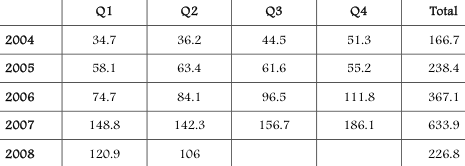

In [15]:
        # table_image_filepath = table_image_filepath.replace("\\", "/")
        # table_img.save(table_image_filepath)
table_img

In [17]:
table_image_filename

'ICDAR-2013-Table-Competition-Corrected_competition-dataset-eu\\eu-002_table_0.jpg'

In [16]:
table_image_filepath

'C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_Image_Structure_PASCAL_VOC/images/ICDAR-2013-Table-Competition-Corrected_competition-dataset-eu/eu-002_table_0.jpg'

In [ ]:
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


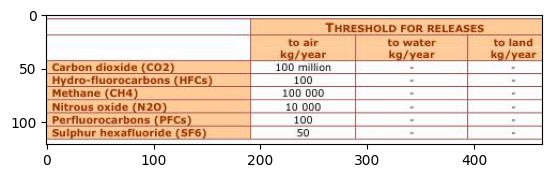

In [ ]:
table_image_filepath = "C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_Image_Structure_PASCAL_VOC/images/competition-dataset-eu_eu-001_table_0.jpg"
test_img = Image.open(table_image_filepath)
plt.imshow(test_img)
plt.show()

In [ ]:
words_path = "C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_Image_Table_Words_JSON/competition-dataset-eu_eu-001_table_0_words.json"
with open(words_path, 'r') as f:
    words = json.load(f)

In [ ]:
annotation_test_path = "C:/Users/PC/Desktop/git/icdar_2013_processing/output/ICDAR-2013.c_PDF_Annotations_JSON/competition-dataset-eu_eu-001_tables.json"
with open(annotation_test_path, 'r') as f:
    annotations = json.load(f)

In [ ]:
annotations[0]
table_annotation_test = annotations[0]
table_annotation_test['cells'][0]

{'pdf_text_tight_bbox': [316.0199890136719,
  298.8058776855469,
  441.2596435546875,
  310.9835205078125],
 'text_content': 'THRESHOLD FOR RELEASES',
 'row_nums': [0],
 'column_nums': [1, 2, 3],
 'is_column_header': True,
 'is_projected_row_header': False,
 'pdf_bbox': [276.30035400390625,
  298.8058776855469,
  482.2666015625,
  310.9835205078125],
 'pdf_text_content': 'THRESHOLD FOR RELEASES'}

In [ ]:
tables[0]

{'cells': [{'pdf_text_tight_bbox': [316.0199890136719,
    298.8058776855469,
    441.2596435546875,
    310.9835205078125],
   'text_content': 'THRESHOLD FOR RELEASES',
   'row_nums': [0],
   'column_nums': [1, 2, 3],
   'is_column_header': True,
   'is_projected_row_header': False,
   'pdf_bbox': [251.90533447265625,
    298.8058776855469,
    482.2666015625,
    311.26019287109375],
   'pdf_text_content': 'THRESHOLD FOR RELEASES'},
  {'pdf_text_tight_bbox': [280.44000244140625,
    311.5368347167969,
    316.6665954589844,
    330.9552001953125],
   'text_content': 'to air\nkg/year',
   'row_nums': [1],
   'column_nums': [1],
   'is_column_header': True,
   'is_projected_row_header': False,
   'pdf_bbox': [251.90533447265625,
    311.26019287109375,
    342.91375732421875,
    331.23602294921875],
   'pdf_text_content': 'to air kg/year'},
  {'pdf_text_tight_bbox': [365.1000061035156,
    311.5368347167969,
    403.0207214355469,
    330.9552001953125],
   'text_content': 'to water\n